In [2]:
# Load Required Libraries
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline


#### Load Data

In [211]:
#Load Calendar Data
calendar = pd.read_csv('./data/calendar.csv')
calendar.head(2)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00


In [212]:
#Load Listings Data
listings = pd.read_csv('./data/listings.csv')
listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48


In [213]:
#Load Reviews Data
reviews = pd.read_csv('./data/reviews.csv')
reviews.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...


## Clean and Transform Data

### Transform Data

#### Rename ID and Price Columns to esnure unique column names across all 3 data frames

In [214]:

listings = listings.rename(columns={'id': 'listing_id'})
reviews = reviews.rename(columns={'id': 'review_id'})
calendar = calendar.rename(columns={'price': 'price_2'})

#### Transform Date Fields

In [215]:
### Function to Convert Currency Columns to Float
listings['host_since'] = pd.to_datetime(listings['host_since'])
listings['first_review'] = pd.to_datetime(listings['first_review'])
listings['last_review'] = pd.to_datetime(listings['last_review'])

reviews["date"]= pd.to_datetime(reviews["date"])
calendar["date"]= pd.to_datetime(calendar["date"]) 


#### Drop Columns which has more than 80% mssing values

In [216]:
def clean_missing_data(df,threshold_column=80):
    """Method to clean the misisng value in dataframe
    
    Args:
        df (Dataframe) : input dataframe to be cleaned
        threshold_column (float) : Threshold for fraction of data to be missing
    
    Returns:
        df (dataframe): cleaned data frame
    """
    #dropping columns which has more than 80% missing values
    missing_columns = [col for col in df.columns if df[col].isnull().any()]
    pct_null= df[missing_columns].isna().sum()*100/df.shape[0]
    missing_features = pct_null[pct_null > threshold_column].index
    df.drop(missing_features, axis=1, inplace=True)
    if len(missing_features) > 0:   
        print('# Columns having more than %s percent missing values: :'%(threshold_column),len(missing_features))
        print("Columns:\n",list(set(missing_features)))
    else:
        print('# Columns having more than %s percent missing values: :'%(threshold_column),len(missing_features))
    return df

In [243]:
listings_clean = clean_missing_data(listings)


# Columns having more than 80 percent missing values: : 2
Columns:
 ['AC', 'Air Conditioning']


In [244]:
calendar_clean = clean_missing_data(calendar)
calendar_clean.head(2)

# Columns having more than 80 percent missing values: : 0


,listing_id,date,available,price_2
0,241032,2016-01-04,t,85.0
1,241032,2016-01-05,t,85.0


In [245]:
reviews_clean = clean_missing_data(reviews)

# Columns having more than 80 percent missing values: : 0


#### Convert Currency Columns to Float

In [246]:
### Function to Convert Currency Columns to Float
def clean_currency_fields(df,columns_to_clean):
    '''
    INPUT 
        df - a dataframe holding the currency columns   
        columns_to_clean - list of columns containing currency values
    OUTPUT
        new_df - a dataframe containing float values of currency columns
    '''
    df[columns_to_clean] = df[columns_to_clean].replace('[\$,]', '', regex=True).astype(float)
    return df
        

In [247]:
calendar_clean = clean_currency_fields(calendar_clean,'price_2')
calendar_clean.head(2)

,listing_id,date,available,price_2
0,241032,2016-01-04,t,85.0
1,241032,2016-01-05,t,85.0


In [248]:
listing_currency_columns = ['price','weekly_price','monthly_price','security_deposit','cleaning_fee']
listings_clean = clean_currency_fields(listings_clean,listing_currency_columns)
listings_clean[listing_currency_columns].head(2)

,price,weekly_price,monthly_price,security_deposit,cleaning_fee
0,85.0,NaN,NaN,NaN,NaN
1,150.0,1000.0,3000.0,100.0,40.0


In [250]:
# dropping columns not relevant to analysis
column_to_drop = ["neighborhood_overview", "notes", "transit","host_thumbnail_url", "medium_url", 
                  "xl_picture_url", "host_neighbourhood","host_acceptance_rate","square_feet","license"]
listings_clean = listings_clean.drop(column_to_drop, axis=1)

KeyError: "['square_feet' 'license'] not found in axis"

#### Amenities

In [223]:
#Clean Amenties Column - Indetify Top 10 Amenties offered in seattle
listings.amenities.head()

0    {TV,"Cable TV",Internet,"Wireless Internet","A...
1    {TV,Internet,"Wireless Internet",Kitchen,"Free...
2    {TV,"Cable TV",Internet,"Wireless Internet","A...
3    {Internet,"Wireless Internet",Kitchen,"Indoor ...
4    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
Name: amenities, dtype: object

In [224]:
unique_amenities=['Other pet(s)',
 'ShampooAir Conditioning',
 'KitchenInternet',
 'Kitchen',
 'Elevator in Building',
 'IronWireless Internet',
 'Family/Kid Friendly',
 'Internet',
 'EssentialsKitchen',
 'Fire Extinguisher',
 'KitchenTV',
 'Wheelchair Accessible',
 'Hair Dryer',
 'DryerTV',
 'Family/Kid FriendlyTV',
 'HeatingInternet',
 'Pets Allowed',
 'Carbon Monoxide DetectorTV',
 'Safety Card',
 'TV',
 'ShampooWireless Internet',
 'Iron',
 'HeatingWireless Internet',
 'Lock on Bedroom DoorCable TV',
 'DryerInternet',
 'Hot Tub',
 'Lock on Bedroom DoorTV',
 'EssentialsCable TV',
 'Wireless InternetWireless Internet',
 'EssentialsTV',
 'HeatingCable TV',
 'IronTV',
 'Smoke DetectorCable TV',
 'Carbon Monoxide DetectorInternet',
 'Fire ExtinguisherWireless Internet',
 'ShampooElevator in Building',
 'ShampooSmoke Detector',
 'ShampooInternet',
 'Free Parking on Premises',
 'ShampooPool',
 '24-Hour Check-inKitchen',
 'Hair DryerInternet',
 'HangersWireless Internet',
 'HangersTV',
 'ShampooKitchenTV',
 'ShampooKitchen',
 'Cable TV',
 '24-Hour Check-inWireless Internet',
 'Buzzer/Wireless Intercom',
 'Hair DryerTV',
 'Smoke DetectorInternet',
 'Laptop Friendly WorkspaceCable TV',
 '24-Hour Check-inTV',
 'EssentialsInternet',
 'First Aid KitInternet',
 'Suitable for Events',
 'ShampooTV',
 'Lock on Bedroom DoorInternet',
 'Hangers',
 'IronInternet',
 'DryerKitchen',
 'Elevator in BuildingTV',
 'First Aid KitWireless Internet',
 'Carbon Monoxide DetectorWireless Internet',
 'Laptop Friendly WorkspaceInternet',
 'Smoke DetectorTV',
 'Pool',
 'Doorman',
 'Suitable for EventsTV',
 'EssentialsFree Parking on Premises',
 'Carbon Monoxide Detector',
 'EssentialsWireless Internet',
 '24-Hour Check-in',
 'Laptop Friendly WorkspaceWireless Internet',
 'Dryer',
 'Hair DryerCable TV',
 'WasherInternet',
 'Washer / Dryer',
 'Lock on Bedroom DoorWireless Internet',
 'HeatingTV',
 'Safety CardCable TV',
 'Smoking Allowed',
 'HangersInternet',
 'Cat(s)',
 'DryerWireless Internet',
 'Indoor Fireplace',
 'Lock on Bedroom DoorKitchen',
 'Indoor FireplaceTV',
 'Gym',
 'Smoke Detector',
 'Safety CardTV',
 'Air Conditioning',
 'Laptop Friendly WorkspaceTV',
 'Hair DryerWireless Internet',
 'Laptop Friendly Workspace',
 'Dog(s)',
 'Smoke DetectorWireless Internet',
 'Lock on Bedroom Door',
 'Breakfast',
 'DryerCable TV',
 'ShampooWheelchair Accessible',
 'ShampooCable TV',
 'Fire ExtinguisherKitchen',
 'Laptop Friendly WorkspaceKitchen',
 'IronCable TV',
 'Family/Kid FriendlyInternet',
 'Wireless Internet',
 'First Aid Kit',
 'Essentials',
 'Heating',
 'Shampoo',
 'Fire ExtinguisherInternet',
 '24-Hour Check-inInternet',
 'Wireless InternetTV',
 'Fire ExtinguisherCable TV',
 'Washer',
 'First Aid KitTV',
 'Fire ExtinguisherTV',
 'Pets live on this property',
 'Family/Kid FriendlyWireless Internet']

In [225]:
def total_count(df, col1, col2, look_for):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    #loop through list of ed types
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the ed type is in the row add 1
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

In [226]:
def clean_and_plot(df, column,look_for, title='Amenities offered in Seattle', plot=True):
    '''
    INPUT 
        df - a dataframe holding the concaneted column 
        column - the column name you want to look through
        look_for - a list of strings you want to search for in each row of df[col]
        title - string the title of your plot
        axis - axis object
        plot - bool providing whether or not you want a plot back
        
    OUTPUT
        new_df - a dataframe with the count of how many individuals
        Displays a plot of pretty things related to the CousinEducation column.
    '''
    new = df[column].value_counts().reset_index()
    new.rename(columns={'index': 'method', column: 'count'}, inplace=True)
    new_df = total_count(new, 'method', 'count', look_for)

    new_df.set_index('method', inplace=True)
    if plot:
        # Plotting a figure of width 10 and height 5
        fig = plt.figure()

        fig.set_size_inches(10, 5)
        (new_df/new_df.sum()).plot(kind='bar', legend=None);
        plt.title(title);
        plt.show()
    props_new_df = new_df/new_df.sum()
    return props_new_df
    

<Figure size 720x360 with 0 Axes>

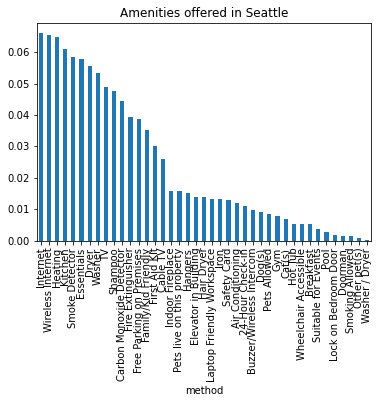

In [227]:
props_df = clean_and_plot(listings,'amenities',unique_amenities)

In [234]:
list(props_df[:10].index)
# So we cank break amenities in 10-15 boolean values and analyze the impact of ameities

['Internet',
 'Wireless Internet',
 'Heating',
 'Kitchen',
 'Smoke Detector',
 'Essentials',
 'Dryer',
 'Washer',
 'TV',
 'Shampoo']

In [237]:
col ='Smoke Detector'
col.count(' ')
'"'+col+'"'

'"Smoke Detector"'

In [239]:
def convert_amenities_to_dummy(df,list_of_columns,col_name):
    for i in range(len(df)):
        for col in list_of_columns:
            if col.count(' ') >= 1:
                col == '"'+col+'"'
            else:
                col == col
            if col in df.loc[i,col_name]:
                df.loc[i,col] = 1
            else:
                df.loc[i,col] = 0
    return df
    

In [240]:
for i in range(len(listings_clean)):
    if 'Internet' in listings_clean.loc[i,'amenities'] :
        listings_clean.loc[i,'Internet'] = 1
    if 'Heating' in listings_clean.loc[i,'amenities'] :
        listings_clean.loc[i,'Heating'] = 1
    if 'Kitchen' in listings_clean.loc[i,'amenities']:
        listings_clean.loc[i,'Kitchen'] = 1 
    if ('"Smoke Detector"' in listings_clean.loc[i,'amenities']) or ('"Carbon Monoxide Detector"' in listings_clean.loc[i,'amenities']):
        listings_clean.loc[i,'Gas_detector'] = 1
    if 'Essentials' in listings_clean.loc[i,'amenities']:
        listings_clean.loc[i,'Essentials'] = 1
    if ('Dryer' in listings_clean.loc[i,'amenities']) or ('Washer' in listings_clean.loc[i,'amenities']):
        listings_clean.loc[i,'Washer_dryer'] = 1
    if 'TV' in listings_clean.loc[i,'amenities']:
        listings_clean.loc[i,'TV'] = 1
    if '"Air Conditioning"' in listings_clean.loc[i,'amenities']:
        listings_clean.loc[i,'AC'] = 1    
    if '"Free Parking on Premises"' in listings_clean.loc[i,'amenities']:
        listings_clean.loc[i,'Free_parking'] = 1    

    
listings_clean.sample(2)

,listing_id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,Internet,Heating,Kitchen,Washer_dryer,TV,Air Conditioning,Gas_detector,Essentials,Free_parking,AC
284,1427103,https://www.airbnb.com/rooms/1427103,20160104002432,2016-01-04,Wallingford Private 1BD Apartment,Our eco-friendly furnished apartment features ...,Our basement apartment is painted with low VOC...,Our eco-friendly furnished apartment features ...,none,Our neighborhood is a Seattle favorite! Extre...,...,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,NaN
2526,5104918,https://www.airbnb.com/rooms/5104918,20160104002432,2016-01-04,Beautiful 2 Bed w/Portage Bay Views,This newly remodeled and modern apartment is ...,"The apartment is a very private space, located...",This newly remodeled and modern apartment is ...,none,"Eastlake is a great, close-in Seattle neighbor...",...,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,NaN


In [231]:
listings_clean.sample(10)

,listing_id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,reviews_per_month,Internet,Heating,Kitchen,Washer_dryer,TV,Air Conditioning,Gas_detector,Essentials,Free_parking
3812,3383329,https://www.airbnb.com/rooms/3383329,20160104002432,2016-01-04,OF THE TREE & CLOUDS. KID FRIENDLY!,"Of the Tree & Clouds' ""Roots"" apartment is 8 b...","The 1-bedroom, ground-floor Roots apartment is...","Of the Tree & Clouds' ""Roots"" apartment is 8 b...",none,It's taken me a while to figure out why Fremon...,...,4.01,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0
3056,5031357,https://www.airbnb.com/rooms/5031357,20160104002432,2016-01-04,NE Seattle Private Entry Studio!,New! Low Rates for Mar/Apr! A private room and...,The private studio is cozy and comfortable in ...,New! Low Rates for Mar/Apr! A private room and...,none,Matthews Beach neighborhood is a super quiet a...,...,0.25,1.0,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0
2737,3418230,https://www.airbnb.com/rooms/3418230,20160104002432,2016-01-04,"Capitol Hill Oasis, Upper",Surrounded by views on one side and a garden o...,This is our living space at the Capitol Hill O...,Surrounded by views on one side and a garden o...,none,NaN,...,0.62,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0
503,1882316,https://www.airbnb.com/rooms/1882316,20160104002432,2016-01-04,Charming Home 2 Blks from Greenlake,"Main floor of our home includes 3 bedrooms, 2 ...",NaN,"Main floor of our home includes 3 bedrooms, 2 ...",none,NaN,...,1.62,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0
383,6714817,https://www.airbnb.com/rooms/6714817,20160104002432,2016-01-04,"Bright, Modern, Seattle Classic.",Our apartment has recently been completely ren...,4 Night minimum for your stay. Our apartment ...,Our apartment has recently been completely ren...,none,Wallingford is a neighborhood in north central...,...,0.31,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN
2430,5319948,https://www.airbnb.com/rooms/5319948,20160104002432,2016-01-04,Cozy charmer w/ sunroom and park,"Enjoy the comforts of living in a warm, quiet ...",The room is the only one on the main floor so ...,"Enjoy the comforts of living in a warm, quiet ...",none,Maple Leaf is an unusual oasis in Seattle with...,...,1.05,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0
3713,1781723,https://www.airbnb.com/rooms/1781723,20160104002432,2016-01-04,Sunny guest room in Fremont,I have a guest bedroom available in my home in...,I am a theatre artist who commutes often betwe...,I have a guest bedroom available in my home in...,none,Delicious things to eat nearby: * Paseo's - t...,...,2.01,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0
2871,458189,https://www.airbnb.com/rooms/458189,20160104002432,2016-01-04,Pure Space - The Modern Room,NaN,Sleek and contemporary style bedroom that is ...,Sleek and contemporary style bedroom that is ...,none,NaN,...,0.40,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0
604,6801095,https://www.airbnb.com/rooms/6801095,20160104002432,2016-01-04,Relaxing & Modern & Easy Access,Enjoy a relaxing stay in my Madison Valley tow...,Modern 4 story townhouse in Madison Valley. Ea...,Enjoy a relaxing stay in my Madison Valley tow...,none,I'm in Madison Valley which is adjacent (down ...,...,1.64,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0
3218,9975073,https://www.airbnb.com/rooms/9975073,20160104002432,2016-01-04,Just steps to Downtown,"Great location in Lower Queen Anne, walking di...",Amazing view of city. The perfect location.,"Great location in Lower Queen Anne, walking di...",none,The Lower Queen Anne neighborhood has wonderfu...,...,NaN,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0
